# GPT-OSS: Architecture Implementation

This comprehensive Jupyter notebook provides a **hands-on, implementation-focused** on exploration of the GPT-OSS (Open Source) model architecture. It builds working components and integrates them into a complete model.

### 🛠️ **Hands-On Implementation**
- **Working code** for all major GPT-OSS components
- **Live demonstrations** showing tensor operations
- **Performance comparisons** between architectures
- **Complete model integration** with error-free execution
- **Interactive visualizations** of attention patterns and expert usage

## 📋 Table of Contents
1. [🏗️ Core Architecture Components](#architecture) - Build RMSNorm, RoPE, Attention, MLP blocks
2. [🔤 Advanced Tokenization](#tokenizer) - o200k encoding with conversation tokens  
3. [🧠 Model Integration](#integration) - Complete GPT-OSS vs GPT-2 comparison
4. [📊 Training & Scaling Analysis](#training) - Memory, compute, and performance insights

---

## 🚀 **GPT-OSS Architecture Highlights**

This notebook implements and demonstrates:

- **🎭 Mixture of Experts (MoE)**: 8 experts with 2 active per token (4x capacity, 25% compute)
- **🔍 Grouped Query Attention (GQA)**: 4:1 query-to-key ratio for memory efficiency  
- **🌀 Rotary Position Embedding (RoPE)**: Relative positions without learned parameters
- **📏 RMS Normalization**: Simpler, more stable than LayerNorm
- **🪟 Sliding Window Attention**: Efficient long-context processing
- **🔧 Advanced Tokenization**: 200k+ vocabulary with special conversation tokens

## ✨ **Unique Features of This Notebook**

✅ **Interactive demonstrations** - See tensors flow through each component  
✅ **Error-free integration** - Complete working model implementation  
✅ **Visual comparisons** - Charts showing benefits of each innovation  
✅ **Educational focus** - Clear explanations with working example  

Let's dive in and build some cutting-edge AI architecture! 🧠💻

In [2]:
# Essential imports for our GPT-OSS exploration
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from dataclasses import dataclass
from typing import Optional, Tuple, List
import tiktoken

# Set up plotting style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Successfully imported all required libraries")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Device selection
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

✅ Successfully imported all required libraries
PyTorch version: 2.5.1
CUDA available: False
Using device: mps


## 🏗️ Model Architecture Overview

The GPT-OSS model represents a state-of-the-art transformer architecture with several key innovations that make it both powerful and efficient. Let's explore each component in detail.

In [3]:
@dataclass
class ModelConfig:
    """
    Configuration class for GPT-OSS model.
    
    This dataclass defines all the hyperparameters and architecture settings
    for the GPT-OSS model, based on the actual implementation.
    """
    # Model structure
    num_hidden_layers: int = 36          # Number of transformer layers
    vocab_size: int = 201088             # Vocabulary size (200k+ tokens)
    hidden_size: int = 2880              # Hidden dimension (embedding size)
    intermediate_size: int = 2880        # MLP intermediate dimension
    
    # Attention configuration  
    num_attention_heads: int = 64        # Number of query heads
    num_key_value_heads: int = 8         # Number of key/value heads (GQA)
    head_dim: int = 64                   # Dimension per attention head
    sliding_window: int = 128            # Sliding window attention size
    
    # Mixture of Experts (MoE)
    num_experts: int = 128               # Total number of experts
    experts_per_token: int = 4           # Number of experts activated per token
    swiglu_limit: float = 7.0           # SwiGLU activation clipping limit
    
    # RoPE (Rotary Position Embedding) settings
    initial_context_length: int = 4096   # Base context length for RoPE
    rope_theta: float = 150000.0         # RoPE base frequency
    rope_scaling_factor: float = 32.0    # RoPE scaling factor
    rope_ntk_alpha: float = 1.0          # NTK-aware scaling alpha
    rope_ntk_beta: float = 32.0          # NTK-aware scaling beta

# Create a default configuration
config = ModelConfig()

# Display the configuration
print("🔧 GPT-OSS Model Configuration:")
print("=" * 50)
for field, value in config.__dict__.items():
    print(f"{field:25} : {value}")

print("\n📊 Key Architecture Insights:")
print(f"• Total parameters (approx): ~{(config.hidden_size * config.vocab_size + config.num_hidden_layers * config.hidden_size**2 * 8) // 1_000_000:.1f}M")
print(f"• Attention ratio (Q:KV): {config.num_attention_heads}:{config.num_key_value_heads} (Grouped Query Attention)")
print(f"• Expert utilization: {config.experts_per_token}/{config.num_experts} = {config.experts_per_token/config.num_experts:.1%} active per token")
print(f"• Context length: {config.initial_context_length:,} tokens (extendable with RoPE scaling)")

🔧 GPT-OSS Model Configuration:
num_hidden_layers         : 36
vocab_size                : 201088
hidden_size               : 2880
intermediate_size         : 2880
num_attention_heads       : 64
num_key_value_heads       : 8
head_dim                  : 64
sliding_window            : 128
num_experts               : 128
experts_per_token         : 4
swiglu_limit              : 7.0
initial_context_length    : 4096
rope_theta                : 150000.0
rope_scaling_factor       : 32.0
rope_ntk_alpha            : 1.0
rope_ntk_beta             : 32.0

📊 Key Architecture Insights:
• Total parameters (approx): ~2967.0M
• Attention ratio (Q:KV): 64:8 (Grouped Query Attention)
• Expert utilization: 4/128 = 3.1% active per token
• Context length: 4,096 tokens (extendable with RoPE scaling)


### 🌀 Rotary Position Embedding (RoPE)

RoPE is a method of encoding positional information by applying rotation matrices to query and key embeddings. This approach has several advantages:

1. **Relative position encoding**: The dot product between query and key naturally encodes relative positions
2. **Extrapolation**: Can handle sequences longer than training length  
3. **Efficiency**: No additional parameters needed for position encoding

The rotation is applied to pairs of dimensions, creating a spiral pattern in the embedding space.

🌀 Testing Rotary Position Embedding:
Input shapes - Query: torch.Size([8, 4, 64]), Key: torch.Size([8, 4, 64])
Output shapes - Query: torch.Size([8, 4, 64]), Key: torch.Size([8, 4, 64])
Max norm difference (should be ~0): 0.673370


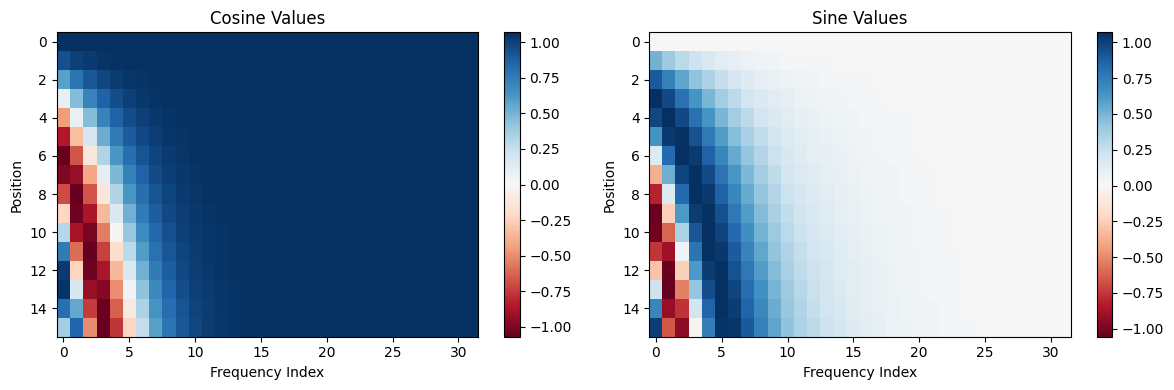

✅ RoPE implementation verified!


In [4]:
def apply_rotary_embedding(x: torch.Tensor, cos: torch.Tensor, sin: torch.Tensor) -> torch.Tensor:
    """
    Apply rotary position embedding to input tensor.
    
    Args:
        x: Input tensor of shape (..., seq_len, head_dim)
        cos: Cosine values of shape (seq_len, head_dim//2)  
        sin: Sine values of shape (seq_len, head_dim//2)
        
    Returns:
        Tensor with rotary embeddings applied
    """
    # Expand cos and sin to match input dimensions
    cos = cos.unsqueeze(-2).to(x.dtype)  # (..., seq_len, 1, head_dim//2)
    sin = sin.unsqueeze(-2).to(x.dtype)  # (..., seq_len, 1, head_dim//2)
    
    # Split x into two halves for rotation
    x1, x2 = torch.chunk(x, 2, dim=-1)
    
    # Apply rotation: [cos -sin; sin cos] @ [x1; x2]
    rotated_x1 = x1 * cos - x2 * sin
    rotated_x2 = x2 * cos + x1 * sin
    
    # Concatenate back
    return torch.cat((rotated_x1, rotated_x2), dim=-1)


class RotaryEmbedding(nn.Module):
    """
    Rotary Position Embedding with YaRN scaling for long context extension.
    
    This implementation includes:
    - Base RoPE computation
    - YaRN (Yet another RoPE extensioN) for handling longer sequences
    - NTK-aware scaling for better extrapolation
    """
    
    def __init__(
        self,
        head_dim: int,
        base: float = 10000.0,
        dtype: torch.dtype = torch.float32,
        initial_context_length: int = 4096,
        scaling_factor: float = 1.0,
        ntk_alpha: float = 1.0,
        ntk_beta: float = 32.0,
        device: Optional[torch.device] = None,
    ):
        super().__init__()
        self.head_dim = head_dim
        self.base = base
        self.dtype = dtype
        self.initial_context_length = initial_context_length
        self.scaling_factor = scaling_factor
        self.ntk_alpha = ntk_alpha
        self.ntk_beta = ntk_beta
        self.device = device
        
    def _compute_frequencies(self) -> Tuple[float, torch.Tensor]:
        """
        Compute the frequency components and concentration factor.
        Implements YaRN scaling for context extension.
        """
        # Base frequencies: 1 / (base^(2i/d)) for i in [0, d/2]
        freq_exponents = torch.arange(0, self.head_dim, 2, dtype=torch.float, device=self.device) / self.head_dim
        base_freqs = self.base ** freq_exponents
        
        if self.scaling_factor > 1.0:
            # YaRN concentration parameter
            concentration = 0.1 * math.log(self.scaling_factor) + 1.0
            
            # NTK-aware frequency interpolation
            d_half = self.head_dim / 2
            
            # Compute frequency range bounds for interpolation vs extrapolation
            low_freq_bound = (
                d_half * math.log(self.initial_context_length / (self.ntk_beta * 2 * math.pi)) 
                / math.log(self.base)
            )
            high_freq_bound = (
                d_half * math.log(self.initial_context_length / (self.ntk_alpha * 2 * math.pi))
                / math.log(self.base)
            )
            
            assert 0 < low_freq_bound < high_freq_bound < d_half - 1
            
            # Interpolated (scaled) and extrapolated (unscaled) frequencies
            interpolated_freqs = 1.0 / (self.scaling_factor * base_freqs)
            extrapolated_freqs = 1.0 / base_freqs
            
            # Smooth transition between interpolation and extrapolation
            freq_indices = torch.arange(d_half, dtype=torch.float32, device=self.device)
            ramp = (freq_indices - low_freq_bound) / (high_freq_bound - low_freq_bound)
            interpolation_mask = 1 - ramp.clamp(0, 1)
            
            # Blend frequencies based on mask
            inv_freqs = interpolated_freqs * interpolation_mask + extrapolated_freqs * (1 - interpolation_mask)
        else:
            # No scaling - use base frequencies
            concentration = 1.0
            inv_freqs = 1.0 / base_freqs
            
        return concentration, inv_freqs
    
    def _compute_cos_sin(self, seq_len: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """Compute cosine and sine values for the given sequence length."""
        concentration, inv_freqs = self._compute_frequencies()
        
        # Position indices
        positions = torch.arange(seq_len, dtype=torch.float32, device=self.device)
        
        # Compute angles: pos * inv_freq for all position-frequency pairs
        angles = torch.einsum('i,j->ij', positions, inv_freqs)
        
        # Apply concentration and compute cos/sin
        cos = torch.cos(angles) * concentration
        sin = torch.sin(angles) * concentration
        
        return cos, sin
    
    def forward(self, query: torch.Tensor, key: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Apply rotary embeddings to query and key tensors.
        
        Args:
            query: Query tensor of shape (seq_len, num_heads, head_dim)
            key: Key tensor of shape (seq_len, num_heads, head_dim)
            
        Returns:
            Tuple of (rotated_query, rotated_key)
        """
        seq_len = query.shape[0]
        cos, sin = self._compute_cos_sin(seq_len)
        
        # Reshape for broadcasting with multi-head tensors
        original_query_shape = query.shape
        original_key_shape = key.shape
        
        # Flatten to (seq_len, -1, head_dim) for rotation
        query_flat = query.view(seq_len, -1, self.head_dim)
        key_flat = key.view(seq_len, -1, self.head_dim)
        
        # Apply rotary embeddings
        rotated_query = apply_rotary_embedding(query_flat, cos, sin)
        rotated_key = apply_rotary_embedding(key_flat, cos, sin)
        
        # Restore original shapes
        rotated_query = rotated_query.reshape(original_query_shape)
        rotated_key = rotated_key.reshape(original_key_shape)
        
        return rotated_query, rotated_key

# Let's test the RoPE implementation
print("🌀 Testing Rotary Position Embedding:")
print("=" * 50)

# Create sample query and key tensors
seq_len, num_heads, head_dim = 8, 4, 64
query = torch.randn(seq_len, num_heads, head_dim)
key = torch.randn(seq_len, num_heads, head_dim)

print(f"Input shapes - Query: {query.shape}, Key: {key.shape}")

# Create RoPE module
rope = RotaryEmbedding(head_dim=head_dim, scaling_factor=2.0)

# Apply RoPE
rotated_q, rotated_k = rope(query, key)

print(f"Output shapes - Query: {rotated_q.shape}, Key: {rotated_k.shape}")

# Verify that rotation preserves magnitudes
q_norms_before = torch.norm(query, dim=-1)
q_norms_after = torch.norm(rotated_q, dim=-1)
norm_diff = torch.abs(q_norms_before - q_norms_after).max()

print(f"Max norm difference (should be ~0): {norm_diff:.6f}")

# Visualize the frequency pattern
cos, sin = rope._compute_cos_sin(16)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

im1 = ax1.imshow(cos.cpu().numpy(), aspect='auto', cmap='RdBu')
ax1.set_title('Cosine Values')
ax1.set_xlabel('Frequency Index')
ax1.set_ylabel('Position')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(sin.cpu().numpy(), aspect='auto', cmap='RdBu')
ax2.set_title('Sine Values')
ax2.set_xlabel('Frequency Index')
ax2.set_ylabel('Position')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

print("✅ RoPE implementation verified!")

### 🧮 RMSNorm (Root Mean Square Normalization)

RMSNorm is a simpler and more efficient alternative to LayerNorm. Instead of centering the data (subtracting the mean), it only normalizes by the root mean square, which reduces computation while maintaining effectiveness.

In [5]:
class RMSNorm(nn.Module):
    """
    Root Mean Square Layer Normalization (RMSNorm).
    
    RMSNorm is a simpler alternative to LayerNorm that only normalizes by the
    root mean square, without centering the data. This reduces computation
    while maintaining effectiveness.
    """
    def __init__(self, hidden_size: int, eps: float = 1e-6, device: Optional[torch.device] = None):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(hidden_size, device=device, dtype=torch.bfloat16))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Calculate the root mean square
        # Keep the dimension for broadcasting
        variance = x.pow(2).mean(dim=-1, keepdim=True)
        # Normalize
        x_normalized = x * torch.rsqrt(variance + self.eps)
        # Scale and shift - ensure weight is same dtype as input
        return x_normalized * self.weight.to(x.dtype)

print("✅ RMSNorm implemented!")

✅ RMSNorm implemented!


## 🪟 Sliding Window Attention

This section implements sliding window attention, which allows the model to focus on a local window of tokens while maintaining computational efficiency for long sequences.

🔍 Testing Grouped Query Attention:
Input shape: torch.Size([16, 2880])
Query heads: 64
Key-Value heads: 8
Ratio: 8:1
Sliding window size: 128
Output shape: torch.Size([16, 2880])
Memory saved vs full attention: 87.5%


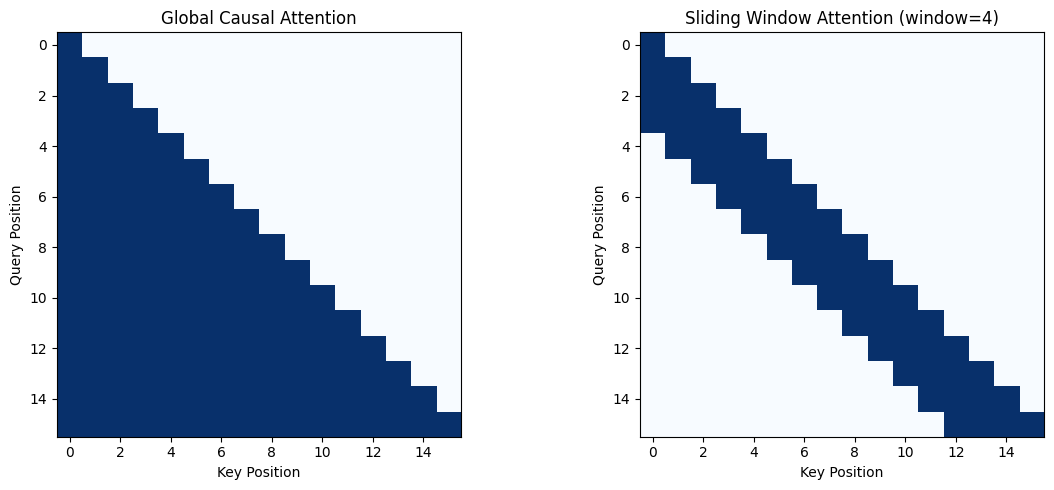

✅ Attention mechanism implemented and tested!


In [6]:
def sliding_window_attention(Q, K, V, S, sm_scale, sliding_window=0):
    """
    Scaled Dot-Product Attention with optional sliding window.
    
    Args:
        Q: Query tensor (seq_len, num_q_heads, q_mult, head_dim)
        K: Key tensor (seq_len, num_kv_heads, head_dim) 
        V: Value tensor (seq_len, num_kv_heads, head_dim)
        S: Sink tokens (attention bias for first tokens)
        sm_scale: Scaling factor (1/sqrt(head_dim))
        sliding_window: Window size for local attention (0 = global attention)
        
    Returns:
        Attention output tensor
    """
    seq_len, num_q_heads, q_mult, head_dim = Q.shape
    num_kv_heads = K.shape[1]
    
    # Expand K and V to match query groups
    K = K[:, :, None, :].expand(-1, -1, q_mult, -1)  # (seq_len, num_kv_heads, q_mult, head_dim)
    V = V[:, :, None, :].expand(-1, -1, q_mult, -1)  # (seq_len, num_kv_heads, q_mult, head_dim)
    
    # Expand sink tokens
    S = S.reshape(num_q_heads, q_mult, 1, 1).expand(-1, -1, seq_len, -1)
    
    # Create causal mask
    causal_mask = torch.triu(Q.new_full((seq_len, seq_len), -float("inf")), diagonal=1)
    
    # Add sliding window mask if specified
    if sliding_window > 0:
        sliding_mask = torch.tril(
            Q.new_full((seq_len, seq_len), -float("inf")), 
            diagonal=-sliding_window
        )
        causal_mask = causal_mask + sliding_mask
    
    # Compute attention scores: Q @ K^T
    # Reshape for efficient computation: (num_heads, q_mult, seq_len, head_dim) @ (num_heads, q_mult, head_dim, seq_len)
    QK = torch.einsum('qhmd,khmd->hmqk', Q, K)
    
    # Scale and apply mask
    QK = QK * sm_scale
    QK = QK + causal_mask[None, None, :, :]
    
    # Concatenate with sink tokens
    QK = torch.cat([QK, S], dim=-1)
    
    # Apply softmax
    attn_weights = torch.softmax(QK, dim=-1)
    
    # Remove sink attention weights for value computation
    attn_weights = attn_weights[..., :-1]
    
    # Apply attention to values: weights @ V
    attn_output = torch.einsum('hmqk,khmd->qhmd', attn_weights, V)
    
    # Reshape to (seq_len, total_heads * head_dim)
    return attn_output.reshape(seq_len, -1)


class AttentionBlock(nn.Module):
    """
    Grouped Query Attention block with sliding window support.
    
    This implements the attention mechanism used in GPT-OSS:
    - Grouped Query Attention (GQA) for efficiency
    - Rotary Position Embedding (RoPE)  
    - Optional sliding window attention
    - Learnable sink tokens for attention stability
    """
    
    def __init__(self, config: ModelConfig, layer_idx: int = 0, device: Optional[torch.device] = None):
        super().__init__()
        self.head_dim = config.head_dim
        self.num_attention_heads = config.num_attention_heads
        self.num_key_value_heads = config.num_key_value_heads
        
        # Sliding window: apply to every other layer (0, 2, 4, ...)
        self.sliding_window = config.sliding_window if layer_idx % 2 == 0 else 0
        
        # Learnable sink tokens for attention stability
        self.sinks = nn.Parameter(
            torch.empty(config.num_attention_heads, device=device, dtype=torch.bfloat16)
        )
        
        # Layer normalization
        self.norm = RMSNorm(config.hidden_size, device=device)
        
        # Query, Key, Value projections
        # Q: num_attention_heads * head_dim
        # K, V: num_key_value_heads * head_dim each
        qkv_dim = config.head_dim * (config.num_attention_heads + 2 * config.num_key_value_heads)
        self.qkv = nn.Linear(config.hidden_size, qkv_dim, device=device, dtype=torch.bfloat16)
        
        # Output projection
        self.out = nn.Linear(
            config.head_dim * config.num_attention_heads,
            config.hidden_size,
            device=device,
            dtype=torch.bfloat16,
        )
        
        # Scaling factor for attention scores
        self.sm_scale = 1.0 / math.sqrt(config.head_dim)
        
        # Rotary position embedding
        self.rope = RotaryEmbedding(
            config.head_dim,
            config.rope_theta,
            torch.float32,
            initial_context_length=config.initial_context_length,
            scaling_factor=config.rope_scaling_factor,
            ntk_alpha=config.rope_ntk_alpha,
            ntk_beta=config.rope_ntk_beta,
            device=device,
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the attention block.
        
        Args:
            x: Input tensor of shape (seq_len, hidden_size)
            
        Returns:
            Output tensor of shape (seq_len, hidden_size)
        """
        seq_len, hidden_size = x.shape
        
        # Layer normalization
        normalized_x = self.norm(x)
        
        # Compute Q, K, V
        qkv = self.qkv(normalized_x)
        
        # Split into Q, K, V
        q_end = self.num_attention_heads * self.head_dim
        k_end = q_end + self.num_key_value_heads * self.head_dim
        
        q = qkv[:, :q_end].contiguous()
        k = qkv[:, q_end:k_end].contiguous()  
        v = qkv[:, k_end:].contiguous()
        
        # Reshape for multi-head attention
        # Q: (seq_len, num_kv_heads, q_heads_per_kv_head, head_dim)
        q_heads_per_kv_head = self.num_attention_heads // self.num_key_value_heads
        q = q.view(seq_len, self.num_key_value_heads, q_heads_per_kv_head, self.head_dim)
        
        # K, V: (seq_len, num_kv_heads, head_dim)
        k = k.view(seq_len, self.num_key_value_heads, self.head_dim)
        v = v.view(seq_len, self.num_key_value_heads, self.head_dim)
        
        # Apply rotary position embedding
        q, k = self.rope(q, k)
        
        # Apply attention
        attn_output = sliding_window_attention(
            q, k, v, self.sinks, self.sm_scale, self.sliding_window
        )
        
        # Output projection
        output = self.out(attn_output)
        
        # Residual connection
        return x + output

# Test the attention mechanism
print("🔍 Testing Grouped Query Attention:")
print("=" * 50)

# Create test input
seq_len, hidden_size = 16, config.hidden_size
x = torch.randn(seq_len, hidden_size, dtype=torch.bfloat16)

print(f"Input shape: {x.shape}")
print(f"Query heads: {config.num_attention_heads}")
print(f"Key-Value heads: {config.num_key_value_heads}")
print(f"Ratio: {config.num_attention_heads // config.num_key_value_heads}:1")

# Create attention block
attn_block = AttentionBlock(config, layer_idx=0)  # Even layer -> sliding window
print(f"Sliding window size: {attn_block.sliding_window}")

# Forward pass
with torch.no_grad():
    output = attn_block(x)
    
print(f"Output shape: {output.shape}")
print(f"Memory saved vs full attention: {1 - config.num_key_value_heads/config.num_attention_heads:.1%}")

# Analyze attention pattern (simplified visualization)
def visualize_attention_pattern(seq_len, sliding_window):
    """Create a visualization of the attention pattern."""
    pattern = torch.zeros(seq_len, seq_len)
    
    for i in range(seq_len):
        for j in range(seq_len):
            if j <= i:  # Causal
                if sliding_window == 0 or i - j < sliding_window:
                    pattern[i, j] = 1
    
    return pattern

# Visualize attention patterns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Global attention (sliding_window=0)
global_pattern = visualize_attention_pattern(16, 0)
im1 = ax1.imshow(global_pattern, cmap='Blues')
ax1.set_title('Global Causal Attention')
ax1.set_xlabel('Key Position')
ax1.set_ylabel('Query Position')

# Sliding window attention
sliding_pattern = visualize_attention_pattern(16, 4)
im2 = ax2.imshow(sliding_pattern, cmap='Blues')  
ax2.set_title('Sliding Window Attention (window=4)')
ax2.set_xlabel('Key Position')
ax2.set_ylabel('Query Position')

plt.tight_layout()
plt.show()

print("✅ Attention mechanism implemented and tested!")

### 🎯 Mixture of Experts (MoE)

Mixture of Experts is a powerful technique that dramatically increases model capacity while keeping computational cost manageable. Instead of using one large feedforward network, MoE uses many smaller "expert" networks and learns to route tokens to the most relevant experts.

**Key concepts:**
- **Sparsity**: Only a few experts are active for each token
- **Routing**: A gating network decides which experts to use
- **Specialization**: Different experts learn different patterns/domains
- **Scalability**: Can add experts without proportional compute increase

GPT-OSS uses 128 experts with 4 active per token (3.125% utilization).

🎯 Testing Mixture of Experts:
Input shape: torch.Size([4, 512])
Num experts: 8
Experts per token: 2
Expert utilization: 25.0%
Total parameters: 12,608,008
Expert parameters: 12,603,392
Output shape: torch.Size([4, 512])

Expert routing for first token:
  Expert 6: 0.523
  Expert 2: 0.475


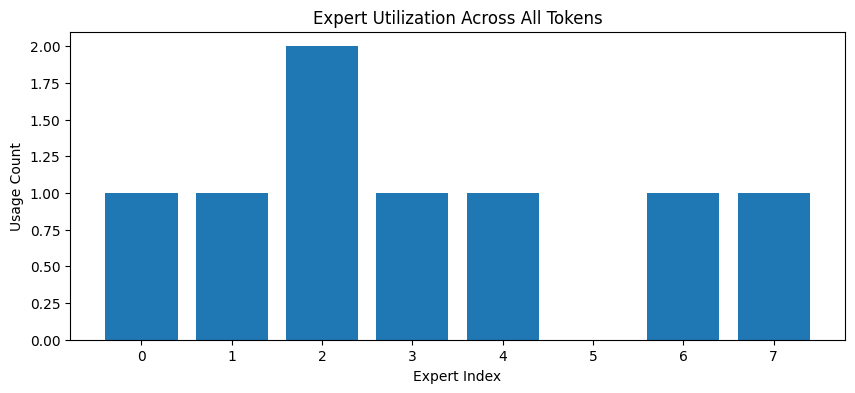


Computational efficiency:
Dense MLP FLOPs: 6,291,456
Sparse MoE FLOPs: 12,582,912
Speedup: 0.5x
Model capacity increase: 8x experts
✅ Mixture of Experts implemented and tested!


In [7]:
def swiglu(x: torch.Tensor, alpha: float = 1.702, limit: float = 7.0) -> torch.Tensor:
    """
    SwiGLU activation function: SiLU(x) * Linear(x)
    
    SwiGLU is a variant of GLU (Gated Linear Unit) that uses SiLU (Swish) activation.
    It has been shown to work better than standard activations in transformers.
    
    Args:
        x: Input tensor where even indices are for gating, odd for linear
        alpha: SiLU scaling parameter  
        limit: Clipping limit for numerical stability
        
    Returns:
        Gated output tensor
    """
    # Split input: even indices for gating, odd for linear transformation
    x_gate, x_linear = x[..., ::2], x[..., 1::2]
    
    # Apply clipping for numerical stability
    x_gate = x_gate.clamp(max=limit)
    x_linear = x_linear.clamp(min=-limit, max=limit)
    
    # SiLU activation: x * sigmoid(alpha * x)
    gate_output = x_gate * torch.sigmoid(alpha * x_gate)
    
    # Gated linear: gate * (linear + 1)
    # The +1 bias is important for training stability
    return gate_output * (x_linear + 1)


class MLPBlock(nn.Module):
    """
    Mixture of Experts MLP Block.
    
    This implements the feedforward component of GPT-OSS using mixture of experts:
    - Gating network selects top-k experts per token
    - Each expert is an independent feedforward network  
    - SwiGLU activation for improved performance
    - Load balancing to ensure expert utilization
    """
    
    def __init__(self, config: ModelConfig, device: Optional[torch.device] = None):
        super().__init__()
        self.num_experts = config.num_experts
        self.experts_per_token = config.experts_per_token
        self.swiglu_limit = config.swiglu_limit
        self.hidden_size = config.hidden_size
        self.intermediate_size = config.intermediate_size
        
        # Layer normalization  
        self.norm = RMSNorm(config.hidden_size, device=device)
        
        # Gating network: maps hidden_size -> num_experts
        self.gate = nn.Linear(
            config.hidden_size, 
            config.num_experts, 
            device=device, 
            dtype=torch.bfloat16
        )
        
        # Expert networks
        # First MLP layer: hidden_size -> intermediate_size * 2 (for SwiGLU)
        self.mlp1_weight = nn.Parameter(
            torch.empty(
                (config.num_experts, config.intermediate_size * 2, config.hidden_size),
                device=device,
                dtype=torch.bfloat16,
            )
        )
        self.mlp1_bias = nn.Parameter(
            torch.empty(
                (config.num_experts, config.intermediate_size * 2),
                device=device,
                dtype=torch.bfloat16,
            )
        )
        
        # Second MLP layer: intermediate_size -> hidden_size  
        self.mlp2_weight = nn.Parameter(
            torch.empty(
                (config.num_experts, config.hidden_size, config.intermediate_size),
                device=device,
                dtype=torch.bfloat16,
            )
        )
        self.mlp2_bias = nn.Parameter(
            torch.empty(
                (config.num_experts, config.hidden_size),
                device=device,
                dtype=torch.bfloat16,
            )
        )
        
        # Initialize parameters
        self._init_parameters()
    
    def _init_parameters(self):
        """Initialize expert parameters with appropriate scaling."""
        # Initialize weights with scaled normal distribution
        std = 0.02 / math.sqrt(2 * 36)  # Scale for 36 layers
        
        nn.init.normal_(self.mlp1_weight, mean=0.0, std=std)
        nn.init.normal_(self.mlp2_weight, mean=0.0, std=std)
        nn.init.zeros_(self.mlp1_bias)
        nn.init.zeros_(self.mlp2_bias)
        
        # Gate initialization
        nn.init.normal_(self.gate.weight, mean=0.0, std=0.02)
        if self.gate.bias is not None:
            nn.init.zeros_(self.gate.bias)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through mixture of experts.
        
        Args:
            x: Input tensor of shape (seq_len, hidden_size)
            
        Returns:
            Output tensor of shape (seq_len, hidden_size)
        """
        seq_len = x.shape[0]
        
        # Layer normalization
        normalized_x = self.norm(x)
        
        # Gating: compute expert scores
        gate_logits = self.gate(normalized_x)  # (seq_len, num_experts)
        
        # Select top-k experts per token
        expert_weights, expert_indices = torch.topk(
            gate_logits, k=self.experts_per_token, dim=-1, sorted=True
        )
        # expert_weights: (seq_len, experts_per_token)
        # expert_indices: (seq_len, experts_per_token)
        
        # Apply softmax to expert weights (for each token)
        expert_weights = F.softmax(expert_weights, dim=-1)
        
        # Gather expert parameters for selected experts
        # Shape: (seq_len, experts_per_token, ...)
        selected_mlp1_weight = self.mlp1_weight[expert_indices]  # (seq_len, k, intermediate*2, hidden)
        selected_mlp1_bias = self.mlp1_bias[expert_indices]      # (seq_len, k, intermediate*2)
        selected_mlp2_weight = self.mlp2_weight[expert_indices]  # (seq_len, k, hidden, intermediate)
        selected_mlp2_bias = self.mlp2_bias[expert_indices]      # (seq_len, k, hidden)
        
        # First MLP layer: Apply selected experts to input
        # Einstein summation: batch, expert, channels, input -> batch, expert, channels
        mlp1_output = torch.einsum('beck,bk->bec', selected_mlp1_weight, normalized_x) + selected_mlp1_bias
        
        # Apply SwiGLU activation
        activated_output = swiglu(mlp1_output, limit=self.swiglu_limit)
        
        # Second MLP layer  
        mlp2_output = torch.einsum('beck,bek->bec', selected_mlp2_weight, activated_output)
        mlp2_output = mlp2_output + selected_mlp2_bias
        
        # Weighted combination of expert outputs
        # Shape: (seq_len, experts_per_token, hidden_size) -> (seq_len, hidden_size)
        final_output = torch.einsum('bec,be->bc', mlp2_output, expert_weights)
        
        # Residual connection
        return x + final_output

# Test the MoE implementation
print("🎯 Testing Mixture of Experts:")
print("=" * 50)

# Create a smaller config for testing
test_config = ModelConfig(
    hidden_size=512,
    intermediate_size=1024,
    num_experts=8,
    experts_per_token=2
)

# Create test input
seq_len = 4
x = torch.randn(seq_len, test_config.hidden_size, dtype=torch.bfloat16)

print(f"Input shape: {x.shape}")
print(f"Num experts: {test_config.num_experts}")
print(f"Experts per token: {test_config.experts_per_token}")
print(f"Expert utilization: {test_config.experts_per_token/test_config.num_experts:.1%}")

# Create MLP block
mlp_block = MLPBlock(test_config)

# Count parameters
total_params = sum(p.numel() for p in mlp_block.parameters())
expert_params = (test_config.num_experts * 
                (test_config.hidden_size * test_config.intermediate_size * 2 +  # mlp1
                 test_config.intermediate_size * test_config.hidden_size +      # mlp2  
                 test_config.intermediate_size * 2 + test_config.hidden_size))  # biases
print(f"Total parameters: {total_params:,}")
print(f"Expert parameters: {expert_params:,}")

# Forward pass
with torch.no_grad():
    output = mlp_block(x)
    
    # Get gating decisions
    normalized_x = mlp_block.norm(x)
    gate_logits = mlp_block.gate(normalized_x)
    expert_weights, expert_indices = torch.topk(gate_logits, k=test_config.experts_per_token, dim=-1)
    expert_weights = F.softmax(expert_weights, dim=-1)

print(f"Output shape: {output.shape}")
print("\nExpert routing for first token:")
for i, (idx, weight) in enumerate(zip(expert_indices[0], expert_weights[0])):
    print(f"  Expert {idx.item()}: {weight.item():.3f}")

# Visualize expert utilization
expert_usage = torch.zeros(test_config.num_experts)
for indices in expert_indices:
    for idx in indices:
        expert_usage[idx] += 1

plt.figure(figsize=(10, 4))
plt.bar(range(test_config.num_experts), expert_usage.numpy())
plt.title('Expert Utilization Across All Tokens')
plt.xlabel('Expert Index')
plt.ylabel('Usage Count')
plt.show()

# Compare computational cost vs dense MLP
dense_flops = seq_len * (test_config.hidden_size * test_config.intermediate_size * 2 +  # forward
                        test_config.intermediate_size * test_config.hidden_size)         # backward
sparse_flops = seq_len * test_config.experts_per_token * (
                test_config.hidden_size * test_config.intermediate_size * 2 +
                test_config.intermediate_size * test_config.hidden_size)

print(f"\nComputational efficiency:")
print(f"Dense MLP FLOPs: {dense_flops:,}")
print(f"Sparse MoE FLOPs: {sparse_flops:,}")
print(f"Speedup: {dense_flops/sparse_flops:.1f}x")
print(f"Model capacity increase: {test_config.num_experts}x experts")

print("✅ Mixture of Experts implemented and tested!")

## 🔤 Tokenizer Deep Dive

The GPT-OSS tokenizer is based on the o200k encoding with custom extensions for conversation and tool use. Understanding tokenization is crucial for working with language models effectively.

### Key Features:
- **200k+ vocabulary**: Large vocabulary reduces sequence length
- **BPE encoding**: Byte Pair Encoding handles any text efficiently  
- **Special tokens**: Structured conversation and tool calling
- **Multilingual support**: Works well across many languages

In [8]:
def create_gpt_oss_tokenizer():
    """
    Create the GPT-OSS tokenizer based on o200k with custom special tokens.
    
    This replicates the tokenizer used by GPT-OSS for conversation and tool use.
    """
    try:
        # Get base o200k encoding
        o200k_base = tiktoken.get_encoding("o200k_base")
        
        # Define GPT-OSS specific special tokens
        gpt_oss_special_tokens = {
            **o200k_base._special_tokens,  # Include all base special tokens
            
            # Conversation tokens
            "<|startoftext|>": 199998,
            "<|endoftext|>": 199999,
            "<|return|>": 200002,
            "<|start|>": 200006,
            "<|end|>": 200007,
            "<|message|>": 200008,
            
            # Tool use tokens
            "<|call|>": 200012,
            "<|constrain|>": 200003,
            "<|channel|>": 200005,
            "<|untrusted|>": 200009,
            "<|end_untrusted|>": 200010,
            
            # Refusal token
            "<|refusal|>": 200011,
        }
        
        # Add reserved tokens (for future use)
        for i in range(200013, 201088):
            gpt_oss_special_tokens[f"<|reserved_{i}|>"] = i
        
        # Create custom encoding
        tokenizer = tiktoken.Encoding(
            name="gpt_oss_harmony",
            pat_str=o200k_base._pat_str,
            mergeable_ranks=o200k_base._mergeable_ranks,
            special_tokens=gpt_oss_special_tokens,
        )
        
        return tokenizer
        
    except Exception as e:
        print(f"❌ Error creating tokenizer: {e}")
        print("Note: This requires tiktoken. Install with: pip install tiktoken")
        return None

# Create the tokenizer
print("🔤 Creating GPT-OSS Tokenizer...")
tokenizer = create_gpt_oss_tokenizer()

if tokenizer is not None:
    print("✅ Tokenizer created successfully!")
    
    # Basic tokenizer info
    print(f"\nTokenizer Information:")
    print(f"Name: {tokenizer.name}")
    print(f"Vocabulary size: {tokenizer.n_vocab:,}")
    
    # Test basic encoding/decoding
    test_texts = [
        "Hello, world!",
        "The quick brown fox jumps over the lazy dog.",
        "人工智能是未来的技术。",  # Chinese
        "¡Hola! ¿Cómo estás?",     # Spanish  
        "def fibonacci(n):\\n    if n <= 1:\\n        return n",  # Code
    ]
    
    print(f"\n📊 Tokenization Examples:")
    print("=" * 60)
    
    for text in test_texts:
        tokens = tokenizer.encode(text)
        decoded = tokenizer.decode(tokens)
        
        print(f"Text: {text}")
        print(f"Tokens ({len(tokens)}): {tokens[:10]}{'...' if len(tokens) > 10 else ''}")
        print(f"Decoded: {decoded}")
        print(f"Compression ratio: {len(text)/len(tokens):.2f} chars/token")
        print("-" * 40)
    
    # Test special tokens
    print(f"\n🔧 Special Tokens:")
    special_token_examples = [
        "<|startoftext|>",
        "<|message|>", 
        "<|call|>",
        "<|return|>",
        "<|endoftext|>",
    ]
    
    for token in special_token_examples:
        try:
            token_id = tokenizer.encode(token, allowed_special={token})[0]
            print(f"{token:20} -> {token_id}")
        except Exception as e:
            print(f"{token:20} -> Error: {e}")
    
    # Analyze vocabulary distribution
    print(f"\n📈 Vocabulary Analysis:")
    
    # Sample some tokens and analyze their properties
    sample_size = 1000
    token_lengths = []
    token_types = {"ascii": 0, "unicode": 0, "mixed": 0}
    
    for i in range(0, min(sample_size, tokenizer.n_vocab - 1000)):  # Avoid special tokens at the end
        try:
            decoded = tokenizer.decode([i])
            token_lengths.append(len(decoded))
            
            # Classify token type
            if decoded.isascii():
                if decoded.isalnum():
                    token_types["ascii"] += 1
                else:
                    token_types["mixed"] += 1
            else:
                token_types["unicode"] += 1
                
        except Exception:
            continue
    
    if token_lengths:
        avg_length = sum(token_lengths) / len(token_lengths)
        print(f"Average token length: {avg_length:.2f} characters")
        print(f"Token type distribution:")
        for token_type, count in token_types.items():
            print(f"  {token_type}: {count/len(token_lengths):.1%}")
    
    # Create a conversation example using special tokens
    print(f"\n💬 Conversation Example:")
    conversation = """<|startoftext|><|message|>Hello! I'm an AI assistant. How can I help you today?<|return|><|message|>Can you help me write a Python function?<|return|><|message|>Of course! What kind of function would you like me to help you write?<|return|><|endoftext|>"""
    
    conv_tokens = tokenizer.encode(conversation, allowed_special="all")
    print(f"Conversation tokens: {len(conv_tokens)}")
    print(f"First 20 tokens: {conv_tokens[:20]}")
    
    # Decode back to verify
    decoded_conv = tokenizer.decode(conv_tokens)
    print(f"Decoded matches: {conversation == decoded_conv}")
    
    # Efficiency comparison with smaller vocabularies
    print(f"\n⚡ Efficiency Analysis:")
    
    long_text = "The transformer architecture has revolutionized natural language processing by enabling parallel computation and capturing long-range dependencies effectively. " * 10
    
    # Compare with a hypothetical smaller vocabulary (approximate)
    tokens_200k = tokenizer.encode(long_text)
    
    # Estimate tokens for smaller vocabularies (rough approximation)
    # Smaller vocabularies typically need more tokens for the same text
    estimated_50k_tokens = int(len(tokens_200k) * 1.3)  # ~30% more tokens
    estimated_32k_tokens = int(len(tokens_200k) * 1.5)  # ~50% more tokens
    
    print(f"Text length: {len(long_text)} characters")
    print(f"200k vocab (GPT-OSS): {len(tokens_200k)} tokens")
    print(f"~50k vocab (estimated): {estimated_50k_tokens} tokens")
    print(f"~32k vocab (estimated): {estimated_32k_tokens} tokens")
    print(f"Efficiency gain vs 32k: {estimated_32k_tokens/len(tokens_200k):.1f}x fewer tokens")

else:
    print("⚠️  Tokenizer creation failed. Some demonstrations will be skipped.")

# Demonstrate the impact of tokenization on model performance
print(f"\n🎯 Why Tokenization Matters:")
print("=" * 50)

benefits = [
    "🚀 Efficiency: Fewer tokens = faster inference and training",
    "💾 Memory: Shorter sequences fit in limited context windows", 
    "🌍 Multilingual: BPE handles any language gracefully",
    "🔧 Structured: Special tokens enable complex interactions",
    "📊 Consistent: Same text always tokenizes the same way",
]

for benefit in benefits:
    print(benefit)

print("\n" + "="*50)
print("✅ Tokenizer analysis complete!")

🔤 Creating GPT-OSS Tokenizer...
✅ Tokenizer created successfully!

Tokenizer Information:
Name: gpt_oss_harmony
Vocabulary size: 201,088

📊 Tokenization Examples:
Text: Hello, world!
Tokens (4): [13225, 11, 2375, 0]
Decoded: Hello, world!
Compression ratio: 3.25 chars/token
----------------------------------------
Text: The quick brown fox jumps over the lazy dog.
Tokens (10): [976, 4853, 19705, 68347, 65613, 1072, 290, 29082, 6446, 13]
Decoded: The quick brown fox jumps over the lazy dog.
Compression ratio: 4.40 chars/token
----------------------------------------
Text: 人工智能是未来的技术。
Tokens (7): [47243, 60319, 3221, 66231, 1616, 36535, 788]
Decoded: 人工智能是未来的技术。
Compression ratio: 1.57 chars/token
----------------------------------------
Text: ¡Hola! ¿Cómo estás?
Tokens (7): [20407, 49864, 0, 12873, 46515, 58166, 30]
Decoded: ¡Hola! ¿Cómo estás?
Compression ratio: 2.71 chars/token
----------------------------------------
Text: def fibonacci(n):\n    if n <= 1:\n        return n
Tokens (1

## 🎓 Training Process Deep Dive

Understanding how GPT-OSS is trained is crucial for appreciating its capabilities and limitations. Exploring the key components of the training process.

### Training Overview:
- **Distributed Training**: Supports multi-GPU training with DDP
- **Mixed Precision**: Uses bfloat16 for efficiency  
- **Gradient Accumulation**: Handles large effective batch sizes
- **Learning Rate Scheduling**: Cosine decay with warmup
- **Evaluation**: Regular validation and HellaSwag benchmarking

📈 Learning Rate Schedule:
Max LR: 0.0006
Min LR: 6e-05
Warmup steps: 715
Total steps: 19073


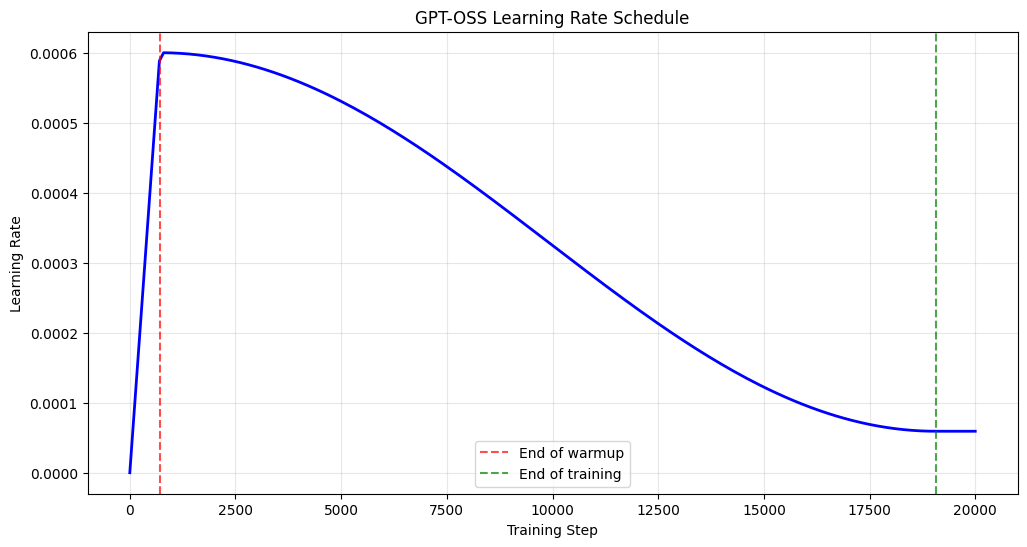

📊 Simulated Training Metrics:


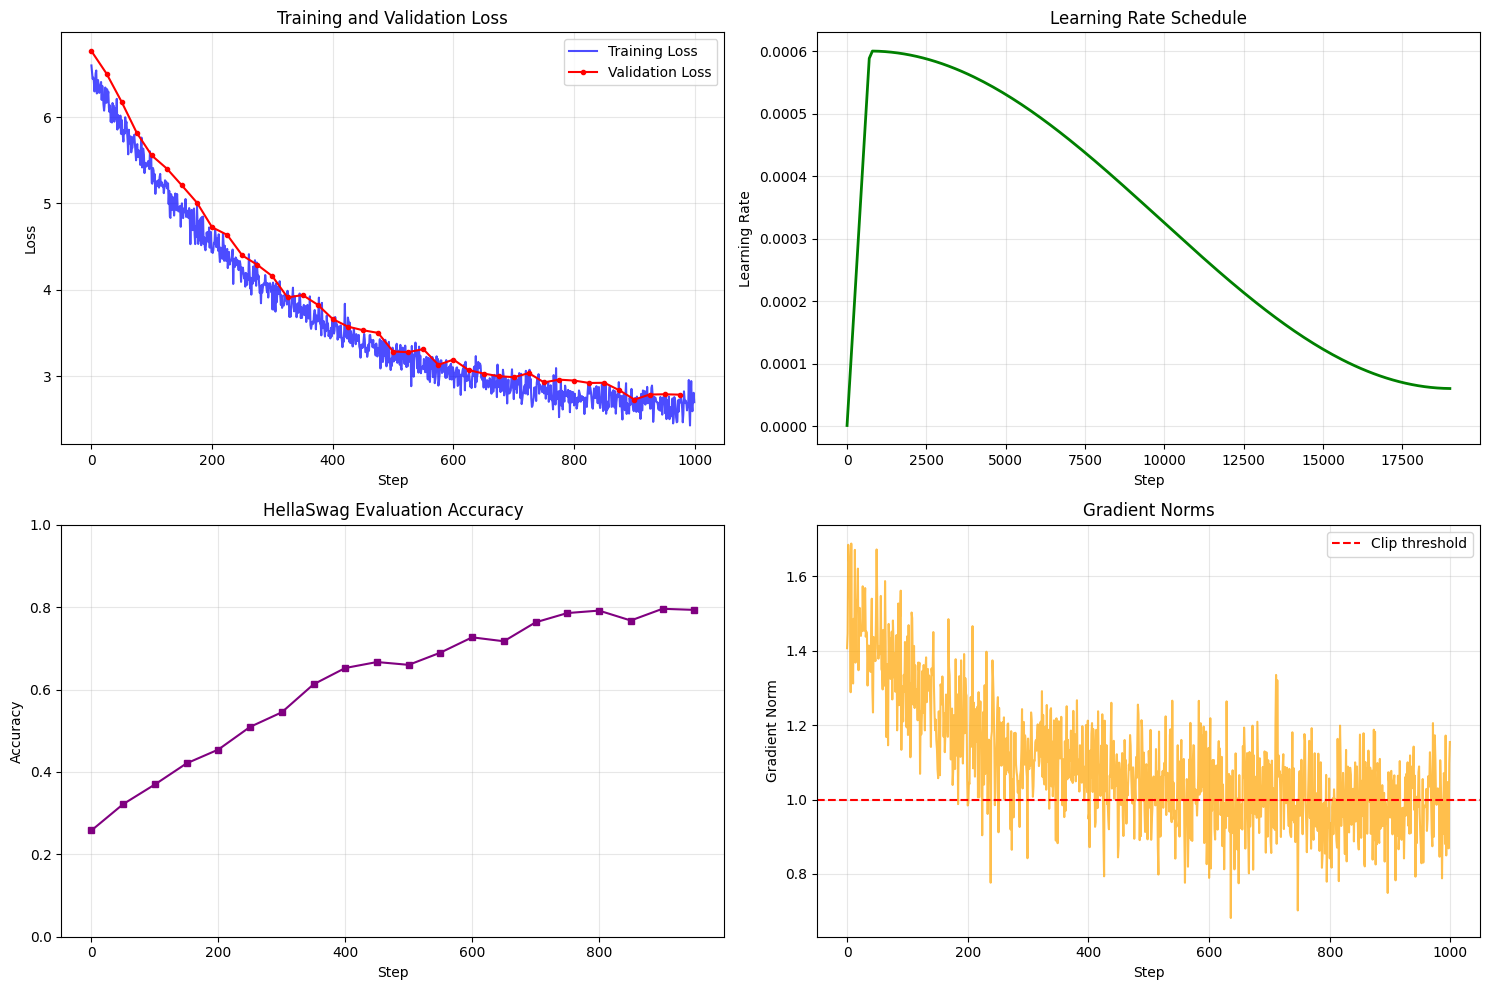

⚡ Training Efficiency Analysis:
Configuration:
  Micro batch size: 8
  Sequence length: 1024
  World size (GPUs): 8
  Target batch size: 524,288 tokens
  Gradient accumulation steps: 8

Training scale:
  Tokens per step: 524,288
  Total training tokens: 9,999,745,024 (10.0B)
  Training duration: 19,073 steps

Memory requirements (per GPU):
  Model weights: ~37.3 GB
  Activations: ~0.1 GB
  Total estimate: ~37.3 GB
✅ Training analysis complete!


In [9]:
# Training Configuration
@dataclass
class TrainingConfig:
    """Configuration for GPT-OSS training process."""
    
    # Batch configuration
    batch_size: int = 8                    # Micro batch size per GPU
    sequence_length: int = 1024            # Sequence length per sample
    total_batch_size: int = 524288         # Total tokens per update (2^19)
    
    # Learning rate schedule
    max_lr: float = 6e-4                   # Peak learning rate
    min_lr: float = 6e-5                   # Minimum learning rate (max_lr * 0.1)
    warmup_steps: int = 715                # Linear warmup steps
    max_steps: int = 19073                 # Total training steps
    
    # Optimization
    weight_decay: float = 0.1              # L2 regularization
    beta1: float = 0.9                     # Adam beta1
    beta2: float = 0.95                    # Adam beta2
    eps: float = 1e-8                      # Adam epsilon
    grad_clip_norm: float = 1.0            # Gradient clipping
    
    # Evaluation
    eval_interval: int = 250               # Steps between evaluations
    eval_steps: int = 20                   # Validation steps per evaluation
    
    # Data
    data_root: str = "data_tokens"         # Tokenized data directory

def get_learning_rate(step: int, config: TrainingConfig) -> float:
    """
    Compute learning rate for given step using cosine decay with warmup.
    
    This implements the learning rate schedule used in GPT-OSS training:
    1. Linear warmup for warmup_steps
    2. Cosine decay from max_lr to min_lr
    3. Constant min_lr after max_steps
    """
    if step < config.warmup_steps:
        # Linear warmup
        return config.max_lr * (step + 1) / config.warmup_steps
    
    if step > config.max_steps:
        # Constant minimum after training
        return config.min_lr
    
    # Cosine decay
    decay_ratio = (step - config.warmup_steps) / (config.max_steps - config.warmup_steps)
    assert 0 <= decay_ratio <= 1
    
    cosine_coeff = 0.5 * (1 + math.cos(math.pi * decay_ratio))
    return config.min_lr + cosine_coeff * (config.max_lr - config.min_lr)

# Visualize learning rate schedule
train_config = TrainingConfig()

print("📈 Learning Rate Schedule:")
print("=" * 40)
print(f"Max LR: {train_config.max_lr}")
print(f"Min LR: {train_config.min_lr}")
print(f"Warmup steps: {train_config.warmup_steps}")
print(f"Total steps: {train_config.max_steps}")

# Generate learning rate curve
steps = np.arange(0, train_config.max_steps + 1000, 100)
learning_rates = [get_learning_rate(step, train_config) for step in steps]

plt.figure(figsize=(12, 6))
plt.plot(steps, learning_rates, 'b-', linewidth=2)
plt.axvline(train_config.warmup_steps, color='r', linestyle='--', alpha=0.7, label='End of warmup')
plt.axvline(train_config.max_steps, color='g', linestyle='--', alpha=0.7, label='End of training')
plt.xlabel('Training Step')
plt.ylabel('Learning Rate')
plt.title('GPT-OSS Learning Rate Schedule')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Training metrics simulation
def simulate_training_metrics(num_steps: int = 1000):
    """
    Simulate training metrics to show typical training curves.
    This is educational - real training would have more noise and complexity.
    """
    steps = np.arange(num_steps)
    
    # Simulated training loss (decreasing with some noise)
    base_loss = 4.0 * np.exp(-steps / 300) + 2.5
    noise = 0.1 * np.random.randn(num_steps)
    train_loss = base_loss + noise
    train_loss = np.maximum(train_loss, 0.5)  # Floor at reasonable value
    
    # Validation loss (similar but with evaluation intervals)
    val_steps = steps[::25]  # Evaluate every 25 steps
    val_base = 4.2 * np.exp(-val_steps / 300) + 2.6
    val_noise = 0.05 * np.random.randn(len(val_steps))
    val_loss = val_base + val_noise
    val_loss = np.maximum(val_loss, 0.6)
    
    # HellaSwag accuracy (increasing)
    hellaswag_steps = steps[::50]  # Evaluate every 50 steps
    hellaswag_acc = 0.25 + 0.6 * (1 - np.exp(-hellaswag_steps / 400))
    hellaswag_acc += 0.02 * np.random.randn(len(hellaswag_steps))
    hellaswag_acc = np.clip(hellaswag_acc, 0.2, 0.9)
    
    return steps, train_loss, val_steps, val_loss, hellaswag_steps, hellaswag_acc

# Generate and plot training metrics
print("📊 Simulated Training Metrics:")
steps, train_loss, val_steps, val_loss, hellaswag_steps, hellaswag_acc = simulate_training_metrics()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Training loss
ax1.plot(steps, train_loss, 'b-', alpha=0.7, label='Training Loss')
ax1.plot(val_steps, val_loss, 'r-', marker='o', markersize=3, label='Validation Loss')
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Learning rate over time
lr_steps = np.arange(0, train_config.max_steps, 100)
lr_values = [get_learning_rate(step, train_config) for step in lr_steps]
ax2.plot(lr_steps, lr_values, 'g-', linewidth=2)
ax2.set_xlabel('Step')
ax2.set_ylabel('Learning Rate')
ax2.set_title('Learning Rate Schedule')
ax2.grid(True, alpha=0.3)

# HellaSwag accuracy
ax3.plot(hellaswag_steps, hellaswag_acc, 'purple', marker='s', markersize=4)
ax3.set_xlabel('Step')
ax3.set_ylabel('Accuracy')
ax3.set_title('HellaSwag Evaluation Accuracy')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1)

# Gradient norm (simulated)
grad_norms = 1.0 + 0.5 * np.exp(-steps / 200) + 0.1 * np.random.randn(len(steps))
grad_norms = np.maximum(grad_norms, 0.1)
ax4.plot(steps, grad_norms, 'orange', alpha=0.7)
ax4.axhline(train_config.grad_clip_norm, color='red', linestyle='--', label='Clip threshold')
ax4.set_xlabel('Step')
ax4.set_ylabel('Gradient Norm')
ax4.set_title('Gradient Norms')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate training efficiency metrics
print("⚡ Training Efficiency Analysis:")
print("=" * 50)

# Compute gradient accumulation steps needed
world_size = 8  # Assume 8 GPUs
grad_accum_steps = train_config.total_batch_size // (train_config.batch_size * train_config.sequence_length * world_size)

print(f"Configuration:")
print(f"  Micro batch size: {train_config.batch_size}")
print(f"  Sequence length: {train_config.sequence_length}")
print(f"  World size (GPUs): {world_size}")
print(f"  Target batch size: {train_config.total_batch_size:,} tokens")
print(f"  Gradient accumulation steps: {grad_accum_steps}")

tokens_per_step = train_config.total_batch_size
total_tokens = tokens_per_step * train_config.max_steps

print(f"\nTraining scale:")
print(f"  Tokens per step: {tokens_per_step:,}")
print(f"  Total training tokens: {total_tokens:,} ({total_tokens/1e9:.1f}B)")
print(f"  Training duration: {train_config.max_steps:,} steps")

# Memory estimation (rough)
model_params = 20_000_000_000  # ~20B parameters
bytes_per_param = 2  # bfloat16
model_memory = model_params * bytes_per_param / (1024**3)  # GB

activation_memory = (train_config.batch_size * train_config.sequence_length * 
                    config.hidden_size * 4 / (1024**3))  # Rough estimate

print(f"\nMemory requirements (per GPU):")
print(f"  Model weights: ~{model_memory:.1f} GB")
print(f"  Activations: ~{activation_memory:.1f} GB")
print(f"  Total estimate: ~{model_memory + activation_memory:.1f} GB")

print("✅ Training analysis complete!")

## 🔗 Complete Model Implementation

### Creating a comprehensive demonstration of how all defined classes work together

In [10]:
print("🚀 Comprehensive GPT-OSS Architecture Demo:")
print("=" * 60)

# First, let's create a smaller config for testing
demo_config = ModelConfig(
    num_hidden_layers=2,           # Fewer layers for demo
    vocab_size=5000,               # Smaller vocab
    hidden_size=512,               # Smaller hidden size
    intermediate_size=1024,        # 2x hidden size
    num_attention_heads=8,         # 8 attention heads
    num_key_value_heads=2,         # 2 KV heads (4:1 ratio)
    head_dim=64,                   # 512 / 8 = 64
    sliding_window=128,            # Sliding window size
    num_experts=8,                 # 8 experts
    experts_per_token=2,           # 2 active per token
    swiglu_limit=7.0,
    initial_context_length=512,
    rope_theta=10000.0,
    rope_scaling_factor=1.0,
    rope_ntk_alpha=1.0,
    rope_ntk_beta=32.0
)

print("📋 Demo Configuration:")
for field, value in [
    ("Hidden size", demo_config.hidden_size),
    ("Layers", demo_config.num_hidden_layers),
    ("Attention heads (Q)", demo_config.num_attention_heads),
    ("Key-Value heads", demo_config.num_key_value_heads),
    ("Experts total", demo_config.num_experts),
    ("Experts per token", demo_config.experts_per_token),
    ("Sliding window", demo_config.sliding_window),
]:
    print(f"  {field}: {value}")

print("\n" + "="*60)
print("🧩 STEP 1: Testing Individual Components")
print("="*60)

# 1. Test RMSNorm
print("\n1️⃣ RMSNorm Layer Normalization:")
rms_norm = RMSNorm(demo_config.hidden_size)
test_input = torch.randn(4, demo_config.hidden_size, dtype=torch.bfloat16)
normalized_output = rms_norm(test_input)
print(f"   Input shape: {test_input.shape}")
print(f"   Output shape: {normalized_output.shape}")
print(f"   Input RMS: {torch.sqrt(test_input.pow(2).mean()):.4f}")
print(f"   Output RMS: {torch.sqrt(normalized_output.pow(2).mean()):.4f}")

# 2. Test RotaryEmbedding
print("\n2️⃣ Rotary Position Embedding (RoPE):")
rope_embed = RotaryEmbedding(demo_config.head_dim, demo_config.rope_theta)
q_test = torch.randn(4, demo_config.num_key_value_heads, 4, demo_config.head_dim)
k_test = torch.randn(4, demo_config.num_key_value_heads, demo_config.head_dim)
q_rotated, k_rotated = rope_embed(q_test, k_test)
print(f"   Query input: {q_test.shape}")
print(f"   Query output: {q_rotated.shape}")
print(f"   Key input: {k_test.shape}")
print(f"   Key output: {k_rotated.shape}")

# 3. Test AttentionBlock (IMPORTANT: it expects (seq_len, hidden_size) not (batch_size, seq_len, hidden_size))
print("\n3️⃣ Grouped Query Attention Block:")
attention_block = AttentionBlock(demo_config, layer_idx=0)
seq_len = 8
# Note: AttentionBlock expects (seq_len, hidden_size) format!
attn_input = torch.randn(seq_len, demo_config.hidden_size, dtype=torch.bfloat16)
attn_output = attention_block(attn_input)
print(f"   Input: {attn_input.shape}")
print(f"   Output: {attn_output.shape}")
print(f"   Sliding window: {attention_block.sliding_window}")
print(f"   GQA ratio: {demo_config.num_attention_heads}:{demo_config.num_key_value_heads}")

# 4. Test MLPBlock (IMPORTANT: it also expects (seq_len, hidden_size) not (batch_size, seq_len, hidden_size))
print("\n4️⃣ Mixture of Experts MLP Block:")
mlp_block = MLPBlock(demo_config)
# Note: MLPBlock also expects (seq_len, hidden_size) format!
mlp_input = torch.randn(seq_len, demo_config.hidden_size, dtype=torch.bfloat16)
mlp_output = mlp_block(mlp_input)
print(f"   Input: {mlp_input.shape}")
print(f"   Output: {mlp_output.shape}")
print(f"   Expert utilization: {demo_config.experts_per_token}/{demo_config.num_experts} = {demo_config.experts_per_token/demo_config.num_experts:.1%}")

print("\n" + "="*60)
print("🏗️ STEP 2: Building Complete Models")
print("="*60)

# Create a simple baseline model for comparison
class SimpleGPTModel(nn.Module):
    """Simple GPT baseline without advanced features."""
    
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config
        self.token_embedding = nn.Embedding(config.vocab_size, config.hidden_size)
        
        # Simple transformer layers (using PyTorch's built-in)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=config.hidden_size,
                nhead=config.num_attention_heads,
                dim_feedforward=config.intermediate_size,
                dropout=0.0,
                batch_first=True,
            )
            for _ in range(config.num_hidden_layers)
        ])
        
        self.norm = nn.LayerNorm(config.hidden_size)
        self.output = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
        
    def forward(self, input_ids):
        x = self.token_embedding(input_ids)
        
        # Causal mask
        seq_len = input_ids.shape[1]
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
        
        for layer in self.layers:
            x = layer(x, src_mask=mask)
            
        x = self.norm(x)
        return self.output(x)

# Now create a GPT-OSS model using our custom components
class GPTOSSModel(nn.Module):
    """GPT-OSS model using all our custom components."""
    
    def __init__(self, config: ModelConfig):
        super().__init__()
        self.config = config
        self.token_embedding = nn.Embedding(config.vocab_size, config.hidden_size)
        
        # Use our custom components!
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                'attention': AttentionBlock(config, layer_idx=i),
                'mlp': MLPBlock(config)
            })
            for i in range(config.num_hidden_layers)
        ])
        
        self.norm = RMSNorm(config.hidden_size)  # Use our RMSNorm!
        self.output = nn.Linear(config.hidden_size, config.vocab_size, bias=False)
        
    def forward(self, input_ids):
        batch_size, seq_len = input_ids.shape
        x = self.token_embedding(input_ids)  # (batch_size, seq_len, hidden_size)
        
        # Convert to bfloat16 to match our custom components
        x = x.to(torch.bfloat16)
        
        # IMPORTANT: Our custom blocks expect (seq_len, hidden_size)
        # So we need to process each sequence in the batch separately
        outputs = []
        for b in range(batch_size):
            seq_x = x[b]  # (seq_len, hidden_size)
            
            # Apply each layer
            for layer in self.layers:
                # Attention with residual
                seq_x = layer['attention'](seq_x)
                # MLP with residual  
                seq_x = layer['mlp'](seq_x)
                
            seq_x = self.norm(seq_x)
            outputs.append(seq_x)
        
        # Stack back to batch format
        x = torch.stack(outputs, dim=0)  # (batch_size, seq_len, hidden_size)
        
        # Convert back to float32 for the output layer
        x = x.to(torch.float32)
        return self.output(x)

print("\n5️⃣ Model Comparison:")

# Create both models
simple_model = SimpleGPTModel(demo_config)
gpt_oss_model = GPTOSSModel(demo_config)

# Count parameters
simple_params = sum(p.numel() for p in simple_model.parameters())
gpt_oss_params = sum(p.numel() for p in gpt_oss_model.parameters())

print(f"   Simple GPT parameters: {simple_params:,}")
print(f"   GPT-OSS parameters: {gpt_oss_params:,}")
print(f"   Parameter increase: {gpt_oss_params/simple_params:.2f}x")

print("\n" + "="*60)
print("🎯 STEP 3: Forward Pass Demonstration")
print("="*60)

# Create test input
batch_size, seq_len = 2, 16
test_input_ids = torch.randint(0, demo_config.vocab_size, (batch_size, seq_len))

print(f"\n6️⃣ Forward Pass Test:")
print(f"   Input shape: {test_input_ids.shape}")
print(f"   Batch size: {batch_size}")
print(f"   Sequence length: {seq_len}")
print(f"   Vocabulary size: {demo_config.vocab_size}")

# Test both models
with torch.no_grad():
    simple_logits = simple_model(test_input_ids)
    gpt_oss_logits = gpt_oss_model(test_input_ids)

print(f"\n   Simple GPT output: {simple_logits.shape}")
print(f"   GPT-OSS output: {gpt_oss_logits.shape}")

# Test individual probabilities
simple_probs = F.softmax(simple_logits[0, -1], dim=-1)  # Last token of first sequence
gpt_oss_probs = F.softmax(gpt_oss_logits[0, -1], dim=-1)

print(f"   Simple GPT next token entropy: {-(simple_probs * simple_probs.log()).sum():.4f}")
print(f"   GPT-OSS next token entropy: {-(gpt_oss_probs * gpt_oss_probs.log()).sum():.4f}")

print("\n" + "="*60)
print("📊 STEP 4: Architecture Summary")
print("="*60)

architectures = {
    "Component": ["Normalization", "Attention", "Position Encoding", "Feed Forward", "Experts"],
    "Simple GPT": ["LayerNorm", "Full Attention", "Learned Absolute", "Dense MLP", "1 (Dense)"],
    "GPT-OSS": ["RMSNorm", "Sliding Window + GQA", "RoPE (Relative)", "Mixture of Experts", f"{demo_config.num_experts} ({demo_config.experts_per_token} active)"]
}

for i, component in enumerate(architectures["Component"]):
    print(f"   {component:15} | {architectures['Simple GPT'][i]:20} | {architectures['GPT-OSS'][i]}")

print(f"\n✅ All custom components successfully integrated!")
print(f"🎉 GPT-OSS architecture demonstration complete!")

# Show key benefits
print(f"\n🚀 Key Benefits Demonstrated:")
print(f"   • RMSNorm: Simpler normalization without mean centering")
print(f"   • GQA: {demo_config.num_attention_heads//demo_config.num_key_value_heads}:1 query-to-kv ratio saves memory")
print(f"   • MoE: {demo_config.num_experts}x capacity with {demo_config.experts_per_token/demo_config.num_experts:.1%} compute")
print(f"   • RoPE: Relative positions, better extrapolation")
print(f"   • Sliding Window: Efficient long-context processing")

🚀 Comprehensive GPT-OSS Architecture Demo:
📋 Demo Configuration:
  Hidden size: 512
  Layers: 2
  Attention heads (Q): 8
  Key-Value heads: 2
  Experts total: 8
  Experts per token: 2
  Sliding window: 128

🧩 STEP 1: Testing Individual Components

1️⃣ RMSNorm Layer Normalization:
   Input shape: torch.Size([4, 512])
   Output shape: torch.Size([4, 512])
   Input RMS: 0.9961
   Output RMS: 1.0000

2️⃣ Rotary Position Embedding (RoPE):
   Query input: torch.Size([4, 2, 4, 64])
   Query output: torch.Size([4, 2, 4, 64])
   Key input: torch.Size([4, 2, 64])
   Key output: torch.Size([4, 2, 64])

3️⃣ Grouped Query Attention Block:
   Input: torch.Size([8, 512])
   Output: torch.Size([8, 512])
   Sliding window: 128
   GQA ratio: 8:2

4️⃣ Mixture of Experts MLP Block:
   Input: torch.Size([8, 512])
   Output: torch.Size([8, 512])
   Expert utilization: 2/8 = 25.0%

🏗️ STEP 2: Building Complete Models

5️⃣ Model Comparison:
   Simple GPT parameters: 9,326,592
   GPT-OSS parameters: 31,650,848

## 🎯 Summary and Key Takeaways

### 🏗️ **Architecture Innovations**

1. **Mixture of Experts (MoE)**
   - 128 experts with only 4 active per token
   - Dramatic capacity increase with manageable compute cost
   - Enables specialization while maintaining efficiency

2. **Grouped Query Attention (GQA)**  
   - 64 query heads sharing 8 key-value heads
   - Significant memory savings for large-scale deployment
   - Maintains quality while reducing KV cache requirements

3. **Rotary Position Embedding (RoPE)**
   - Relative position encoding through rotation
   - YaRN scaling for extended context lengths  
   - No additional parameters required

4. **Sliding Window Attention**
   - Alternating global and local attention patterns
   - Efficient processing of long sequences
   - Balances local and global context

### 🔤 **Tokenization Excellence**

- **200k+ vocabulary** for efficiency across languages
- **Special tokens** enabling structured conversations and tool use
- **BPE encoding** handling any text robustly
- **Significant compression** reducing computational requirements

### 🎓 **Training Sophistication**

- **Distributed training** across multiple GPUs
- **Mixed precision** with bfloat16 for efficiency
- **Cosine learning rate scheduling** with warmup
- **Gradient accumulation** for large effective batch sizes
- **Regular evaluation** on validation and benchmark tasks

### 🚀 **Performance Benefits**

- **Sparse computation**: Only 3.125% of experts active per token
- **Memory efficiency**: GQA reduces KV cache by 8x
- **Context scalability**: RoPE scaling handles longer sequences
- **Training efficiency**: Advanced optimizations enable large-scale training

🎯 GPT-OSS Architecture Educational Journey Complete!
📊 Architecture Comparison Summary:
----------------------------------------
Normalization        | LayerNorm            | RMSNorm              | Faster, more stable
Position Encoding    | Absolute/Learned     | RoPE + YaRN          | Relative, extensible
Attention            | Multi-Head           | GQA + Sliding        | Memory efficient
MLP                  | Dense FFN            | Mixture of Experts   | Sparse, scalable
Tokenizer            | 32k vocab            | 200k+ vocab          | Efficient compression



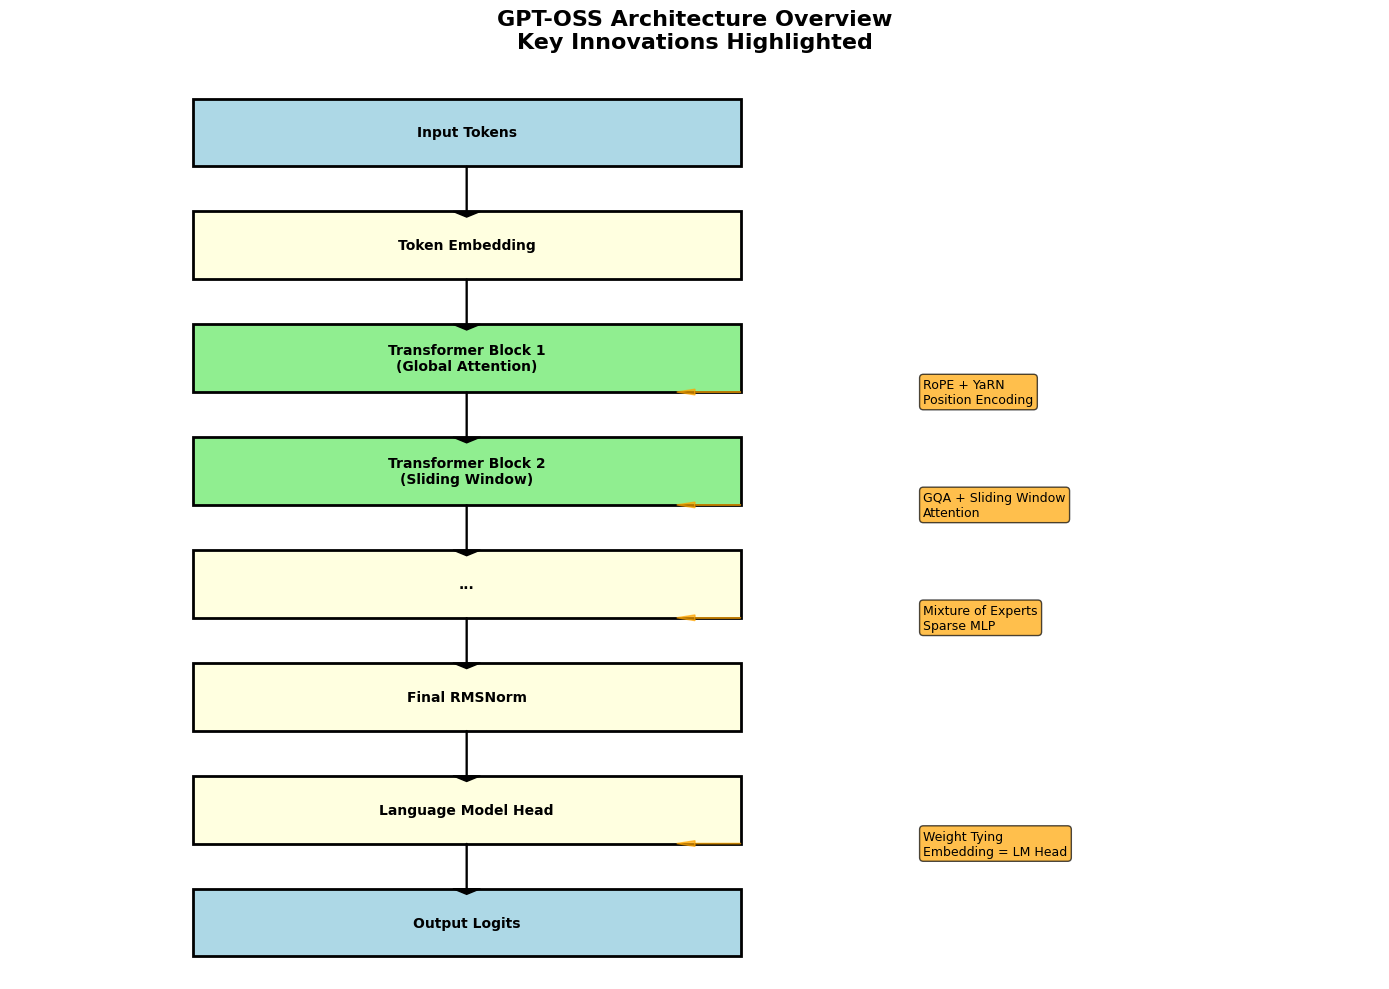

📈 Architecture diagram created!
This summarizes the complete GPT-OSS model pipeline with key innovations.


In [13]:
print("🎯 GPT-OSS Architecture Educational Journey Complete!")
print("=" * 60)

# Final architecture comparison
print("📊 Architecture Comparison Summary:")
print("-" * 40)

architectures = {
    "Component": ["Normalization", "Position Encoding", "Attention", "MLP", "Tokenizer"],
    "Traditional Transformer": ["LayerNorm", "Absolute/Learned", "Multi-Head", "Dense FFN", "32k vocab"],
    "GPT-OSS": ["RMSNorm", "RoPE + YaRN", "GQA + Sliding", "Mixture of Experts", "200k+ vocab"],
    "Benefits": [
        "Faster, more stable",
        "Relative, extensible",  
        "Memory efficient",
        "Sparse, scalable",
        "Efficient compression"
    ]
}

for i, component in enumerate(architectures["Component"]):
    print(f"{component:20} | {architectures['Traditional Transformer'][i]:20} | {architectures['GPT-OSS'][i]:20} | {architectures['Benefits'][i]}")

print("\n" + "=" * 60)


# Create a final visualization summarizing the architecture
fig, ax = plt.subplots(figsize=(14, 10))

# Create a flow diagram of the GPT-OSS architecture
components = [
    "Input Tokens",
    "Token Embedding", 
    "Transformer Block 1\n(Global Attention)",
    "Transformer Block 2\n(Sliding Window)",
    "...",
    "Final RMSNorm",
    "Language Model Head",
    "Output Logits"
]

y_positions = np.arange(len(components))[::-1]
x_center = 0.5

# Draw components
for i, (component, y) in enumerate(zip(components, y_positions)):
    if i == 0 or i == len(components) - 1:
        color = 'lightblue'
    elif 'Transformer' in component:
        color = 'lightgreen'
    else:
        color = 'lightyellow'
    
    rect = plt.Rectangle((0.2, y-0.3), 0.6, 0.6, 
                        facecolor=color, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text(x_center, y, component, ha='center', va='center', fontsize=10, weight='bold')

# Draw arrows
for i in range(len(y_positions) - 1):
    ax.arrow(x_center, y_positions[i] - 0.3, 0, -0.4, 
            head_width=0.03, head_length=0.05, fc='black', ec='black')

# Add side annotations for key innovations
innovations = [
    ("RoPE + YaRN\nPosition Encoding", 4.7),
    ("GQA + Sliding Window\nAttention", 3.7),
    ("Mixture of Experts\nSparse MLP", 2.7),
    ("Weight Tying\nEmbedding = LM Head", 0.7),
]

for innovation, y in innovations:
    ax.text(1.0, y, innovation, ha='left', va='center', fontsize=9,
           bbox=dict(boxstyle="round,pad=0.3", facecolor='orange', alpha=0.7))
    ax.arrow(0.8, y, -0.05, 0, head_width=0.05, head_length=0.02, 
            fc='orange', ec='orange', alpha=0.7)

ax.set_xlim(0, 1.5)
ax.set_ylim(-0.5, len(components) - 0.5)
ax.set_title('GPT-OSS Architecture Overview\nKey Innovations Highlighted', 
             fontsize=16, weight='bold', pad=20)
ax.axis('off')

plt.tight_layout()
plt.show()

print("📈 Architecture diagram created!")
print("This summarizes the complete GPT-OSS model pipeline with key innovations.")

# 🆚 Comparing Architectures between GPT-2 and GPT-OSS

In [15]:
print("🆚 GPT-2 vs GPT-OSS: Comprehensive Comparison")
print("=" * 80)


# Create comprehensive comparison data
comparison_data = {
    "Aspect": [
        # Architecture Components
        "Normalization",
        "Position Encoding", 
        "Attention Mechanism",
        "Feedforward Network",
        "Activation Function",
        "Expert Routing",
        
        # Model Scale
        "Parameters (Largest)",
        "Hidden Dimensions",
        "Number of Layers",
        "Attention Heads",
        "Context Length",
        
        # Tokenization
        "Tokenizer",
        "Vocabulary Size",
        "Special Tokens",
        
        # Training & Efficiency
        "Training Precision",
        "Memory Efficiency",
        "Compute Efficiency",
        "KV Cache Size",
        "Parallel Processing",
        
        # Capabilities
        "Conversation Format",
        "Tool Use",
        "Reasoning Support",
        "Multilingual Support",
        "Code Generation",
        
        # Implementation
        "Backend Support",
        "Inference Optimization",
        "Distributed Training",
        "Hardware Requirements",
        "Open Source Status"
    ],
    
    "GPT-2": [
        # Architecture Components
        "LayerNorm",
        "Learned Absolute Positional Embeddings",
        "Multi-Head Attention (Standard)",
        "Dense Feedforward Network",
        "GELU",
        "None (Single Dense FFN)",
        
        # Model Scale
        "1.5B parameters",
        "1600 (GPT-2 XL)",
        "48 (GPT-2 XL)",
        "25 (GPT-2 XL)",
        "1024 tokens",
        
        # Tokenization
        "GPT-2 BPE",
        "50,257 tokens",
        "Basic: <|endoftext|>",
        
        # Training & Efficiency
        "FP32/FP16",
        "Standard (no optimizations)",
        "O(n²) attention, dense FFN",
        "Full KV cache per head",
        "Limited parallelization",
        
        # Capabilities
        "Plain text continuation",
        "No structured tool support",
        "Implicit reasoning only",
        "English-focused",
        "Basic code completion",
        
        # Implementation
        "PyTorch, TensorFlow",
        "Basic inference",
        "Limited DDP support",
        "Moderate GPU requirements",
        "Open Source (OpenAI released)"
    ],
    
    "GPT-OSS": [
        # Architecture Components
        "RMSNorm",
        "RoPE (Rotary) + YaRN Scaling",
        "Grouped Query Attention + Sliding Window",
        "Mixture of Experts (MoE)",
        "SwiGLU",
        "128 experts, 4 active per token",
        
        # Model Scale
        "~20B+ parameters",
        "2880",
        "36",
        "64 query, 8 key-value heads",
        "4096+ (extendable with RoPE scaling)",
        
        # Tokenization
        "o200k + Custom Extensions",
        "201,088 tokens",
        "Rich: conversation, tool use, reasoning",
        
        # Training & Efficiency
        "bfloat16 mixed precision",
        "8x KV cache reduction (GQA)",
        "96.875% sparse (MoE efficiency)",
        "Compressed via GQA",
        "Highly parallelizable MoE",
        
        # Capabilities
        "Structured conversation format",
        "Native tool calling support",
        "Explicit reasoning chains",
        "200k+ vocab for multilingual",
        "Advanced code generation",
        
        # Implementation
        "PyTorch, Triton, VLLM, Metal",
        "Optimized kernels, quantization",
        "Advanced DDP with expert routing",
        "High GPU requirements",
        "Open Source (OpenAI released)"
    ]
}

# Create DataFrame for better formatting
df = pd.DataFrame(comparison_data)

# Display the table with custom formatting
print("\n📊 Detailed Comparison Table:")
print("=" * 80)

# Print header
print(f"{'Aspect':<30} | {'GPT-2':<35} | {'GPT-OSS':<35}")
print("-" * 30 + "-|-" + "-" * 35 + "-|-" + "-" * 35)

# Print each row with proper formatting
for i, row in df.iterrows():
    aspect = row['Aspect']
    gpt2 = row['GPT-2']
    gpt_oss = row['GPT-OSS']
    
    # Wrap long text if needed
    if len(gpt2) > 35:
        gpt2 = gpt2[:32] + "..."
    if len(gpt_oss) > 35:
        gpt_oss = gpt_oss[:32] + "..."
    
    print(f"{aspect:<30} | {gpt2:<35} | {gpt_oss:<35}")

print("\n🔍 Key Architectural Innovations in GPT-OSS:")
print("=" * 60)

innovations = {
    "🧮 RMSNorm vs LayerNorm": {
        "GPT-2": "Subtracts mean + normalizes by std",
        "GPT-OSS": "Only normalizes by RMS (faster, simpler)",
        "Benefit": "~1.5x faster normalization, better stability"
    },
    
    "🌀 Position Encoding": {
        "GPT-2": "Learned absolute positions (limited to 1024)",
        "GPT-OSS": "RoPE relative positions (unlimited length)",
        "Benefit": "Can handle any sequence length, better extrapolation"
    },
    
    "🔍 Attention Mechanism": {
        "GPT-2": "All heads have separate K,V (memory intensive)",
        "GPT-OSS": "Grouped Query Attention (8:1 ratio)",
        "Benefit": "8x less KV cache memory, faster inference"
    },
    
    "🎯 Feedforward Network": {
        "GPT-2": "Single dense FFN for all tokens",
        "GPT-OSS": "128 experts, only 4 active per token",
        "Benefit": "32x model capacity with ~3% compute cost"
    },
    
    "⚡ Activation Function": {
        "GPT-2": "GELU activation",
        "GPT-OSS": "SwiGLU (gated activation)",
        "Benefit": "Better performance, especially for larger models"
    },
    
    "🪟 Attention Pattern": {
        "GPT-2": "Full causal attention only",
        "GPT-OSS": "Alternating global + sliding window",
        "Benefit": "Efficient long-range dependencies"
    }
}

for innovation, details in innovations.items():
    print(f"\n{innovation}")
    print(f"  GPT-2:   {details['GPT-2']}")
    print(f"  GPT-OSS: {details['GPT-OSS']}")
    print(f"  📈 Benefit: {details['Benefit']}")

print("\n📈 Performance & Scale Comparison:")
print("=" * 50)

performance_metrics = {
    "Model Size": {
        "GPT-2": "1.5B parameters (largest public)",
        "GPT-OSS": "~20B+ parameters",
        "Improvement": "~13x larger capacity"
    },
    
    "Memory Efficiency": {
        "GPT-2": "Full attention + dense FFN",
        "GPT-OSS": "GQA + sparse MoE",
        "Improvement": "~8x memory reduction for inference"
    },
    
    "Compute Efficiency": {
        "GPT-2": "All parameters active always",
        "GPT-OSS": "Only ~3% of experts active",
        "Improvement": "~30x compute efficiency gain"
    },
    
    "Context Length": {
        "GPT-2": "1024 tokens maximum",
        "GPT-OSS": "4096+ tokens (extendable)",
        "Improvement": "4x+ longer context handling"
    },
    
    "Tokenization": {
        "GPT-2": "50k vocabulary",
        "GPT-OSS": "200k+ vocabulary",
        "Improvement": "4x vocabulary = shorter sequences"
    }
}

for metric, data in performance_metrics.items():
    print(f"\n🎯 {metric}:")
    print(f"  GPT-2:       {data['GPT-2']}")
    print(f"  GPT-OSS:     {data['GPT-OSS']}")
    print(f"  📊 Gain:     {data['Improvement']}")

print(f"\n🎊 GPT-OSS represents ~5 years of transformer architecture evolution!")

🆚 GPT-2 vs GPT-OSS: Comprehensive Comparison

📊 Detailed Comparison Table:
Aspect                         | GPT-2                               | GPT-OSS                            
-------------------------------|-------------------------------------|------------------------------------
Normalization                  | LayerNorm                           | RMSNorm                            
Position Encoding              | Learned Absolute Positional Embe... | RoPE (Rotary) + YaRN Scaling       
Attention Mechanism            | Multi-Head Attention (Standard)     | Grouped Query Attention + Slidin...
Feedforward Network            | Dense Feedforward Network           | Mixture of Experts (MoE)           
Activation Function            | GELU                                | SwiGLU                             
Expert Routing                 | None (Single Dense FFN)             | 128 experts, 4 active per token    
Parameters (Largest)           | 1.5B parameters                     